In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Функции

In [50]:
def calculate_iqr(column: pd.Series) -> tuple[float, float]:
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1

    lower_q = Q1 - 1.5 * IQR
    upper_q = Q3 + 1.5 * IQR
    
    return lower_q, upper_q

## Анализ

In [51]:
TOTAL_DELITIONS = 0

origin_df = pd.read_csv("data/AB_NYC_2019.csv")
df = origin_df.copy()

print("Total lines:", df.shape[0])
print("Columns:")
for col in df.columns:
    print(" -", col)

Total lines: 48895
Columns:
 - id
 - name
 - host_id
 - host_name
 - neighbourhood_group
 - neighbourhood
 - latitude
 - longitude
 - room_type
 - price
 - minimum_nights
 - number_of_reviews
 - last_review
 - reviews_per_month
 - calculated_host_listings_count
 - availability_365


### Анализ цен

In [52]:
column = df["price"]

print("Origin stat:")
print("Min:", column.min())
print("Max:", column.max())
print("Mean:", column.mean())

print("\nLess or equal zero price elements:", len(column[column <= 0]))
df = df[column > 0]
column = df["price"]

l, u = calculate_iqr(column)
print("IQR range:", l, u)

print("\nNormal stat:")
iqr_mask_normal = (column >= l) & (column <= u)
print("Min:", column[iqr_mask_normal].min())
print("Max:", column[iqr_mask_normal].max())
print("Mean:", column[iqr_mask_normal].mean())

print("\nEmissions stat:")
iqr_mask_emissions = column > u
print("Min:", column[iqr_mask_emissions].min())
print("Max:", column[iqr_mask_emissions].max())
print("Mean:", column[iqr_mask_emissions].mean())

print(f"\nNormal values share: {(len(column[iqr_mask_normal]) / len(column) * 100):.3f}%")


Origin stat:
Min: 0
Max: 10000
Mean: 152.7206871868289

Less or equal zero price elements: 11
IQR range: -90.0 334.0

Normal stat:
Min: 10
Max: 334
Mean: 119.99906342568391

Emissions stat:
Min: 335
Max: 10000
Mean: 658.7755720053835

Normal values share: 93.920%


Из вывода можно понять, что в таблице были предложения с ценой в 0 долларов, что является ошибочными значениями, отбрасываем их.
Также можно заметить, что максимальное значение цены сильно больше среднего, что свидетельствует о выбросах. Для того, чтобы отсеять их подсчитаем IQR.
Увдим, что в столбце действительно имеются выбросы, а именно значения больше 334 долларов. Доля нормальных значений ~94%.

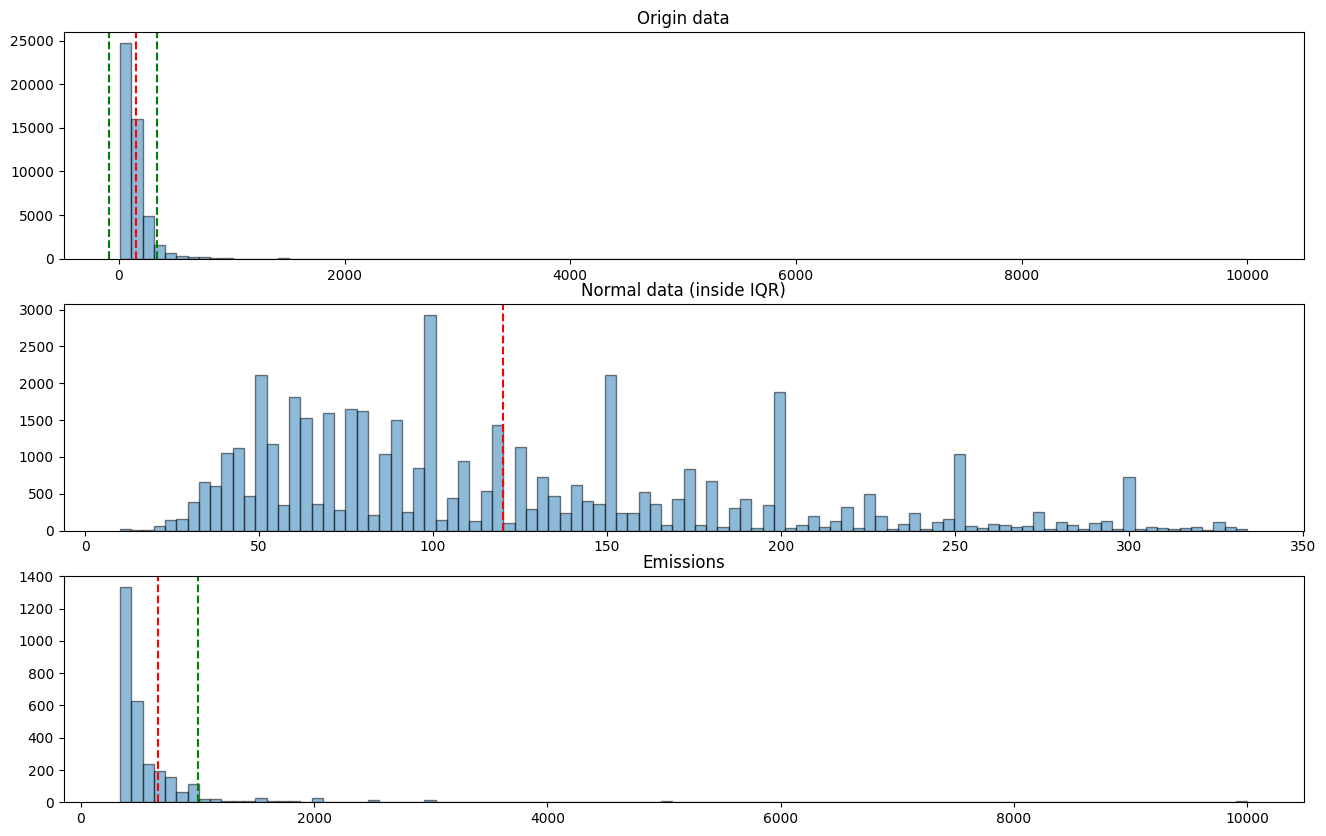

In [53]:
_, ax = plt.subplots(nrows=3, ncols=1, figsize=(16, 10))

ax[0].set_title("Origin data")
ax[0].hist(column, bins=100, alpha=0.5, edgecolor='black')
ax[0].axvline(x=l, color='green', linestyle='--')
ax[0].axvline(x=u, color='green', linestyle='--')
ax[0].axvline(x=column.mean(), color='red', linestyle='--')

col = column[iqr_mask_normal]
ax[1].set_title("Normal data (inside IQR)")
ax[1].hist(col, bins=100, alpha=0.5, edgecolor='black')
ax[1].axvline(x=col.mean(), color='red', linestyle='--')

col = column[iqr_mask_emissions]
ax[2].set_title("Emissions")
ax[2].hist(col, bins=100, alpha=0.5, edgecolor='black')
ax[2].axvline(x=col.mean(), color='red', linestyle='--')
ax[2].axvline(x=1000, color='green', linestyle='--')

plt.show()

Из третьего графика можно заметить, что значения до 1000 долларов могут встречаться достаточно часто, нужно попробовать включить их в нормальный дииапазон ии проверить.

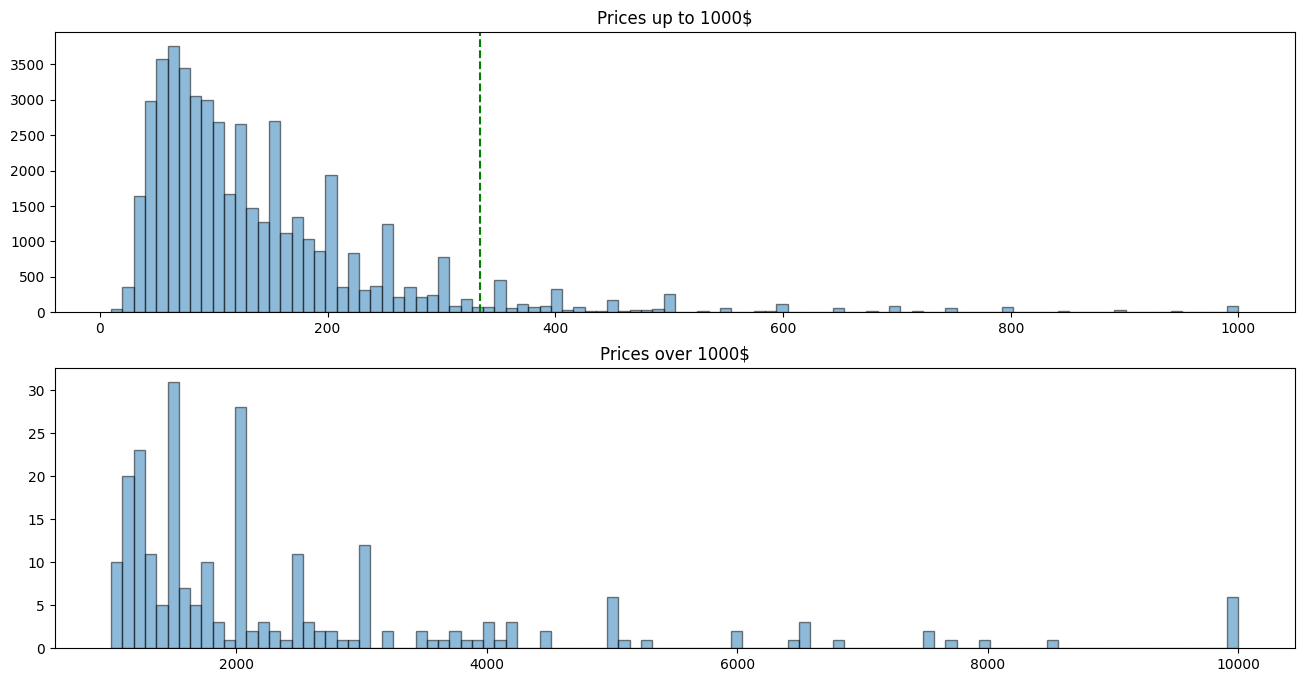

In [54]:
_, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

col = column[column <= 1000]
ax[0].set_title("Prices up to 1000$")
ax[0].hist(col, bins=100, alpha=0.5, edgecolor='black')
ax[0].axvline(x=u, color="green", linestyle="--")

col = column[column > 1000]
ax[1].set_title("Prices over 1000$")
ax[1].hist(col, bins=100, alpha=0.5, edgecolor='black')

plt.show()

Из более точной гистограммы видно, что суммы от Q3 до 1000 долларов всё-таки достаточно разрежены, и являются выбросами.

В дальнейшем имеет смысл анализировать выбросы отдельно, но пока мы их просто отбросим.

In [55]:
to_delition = len(df[iqr_mask_emissions])
print("Count of elements to deletion:", to_delition)
TOTAL_DELITIONS += to_delition

df = df[iqr_mask_normal]
print("Final values:")
print("Min:", df["price"].min())
print("Max:", df["price"].max())
print("Mean:", df["price"].mean())

Count of elements to deletion: 2972
Final values:
Min: 10
Max: 334
Mean: 119.99906342568391


### Анализ колонок арендодателей

In [56]:
column = df["host_id"]
print("Total host IDs:", len(column.unique()))
print(f"Unique ID shape: {(len(column.unique()) / df.shape[0] * 100):.3f}%")

Total host IDs: 35387
Unique ID shape: 77.076%


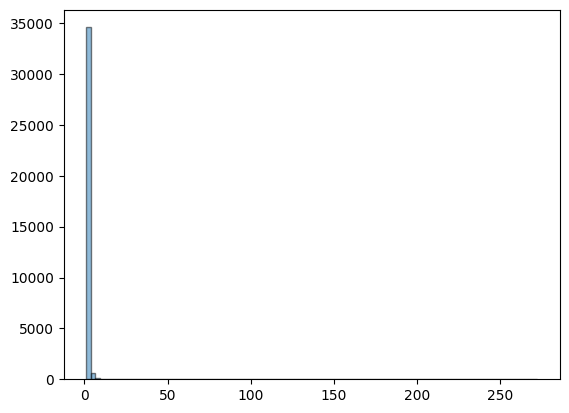

In [57]:
uni = column.value_counts()

plt.hist(uni, bins=100, alpha=0.5, edgecolor="black")
plt.show()

Всего в таблице 35387 уникальных ID, при этом они занимают 77% от общего количества записей в таблице. При отсутвии баланса количества помещений на одного арендодателя получается, что нет особого смысла учитывать колонки host в модели.
Учёт ID арендодателя может помочь при рассчёте стоимости жилья, так как может быть корелляция между предложениями арендодателя и ценой жилья, но в данном случае учёт ID будет мешать.

In [58]:
# Удаление лишних колонок
df = df.drop(["id", "name", "host_id", "host_name"], axis=1)

### Время простоя жилья

IQR range: -325.5 542.5
Count of '0' values 16844
Count of '365' values: 1101


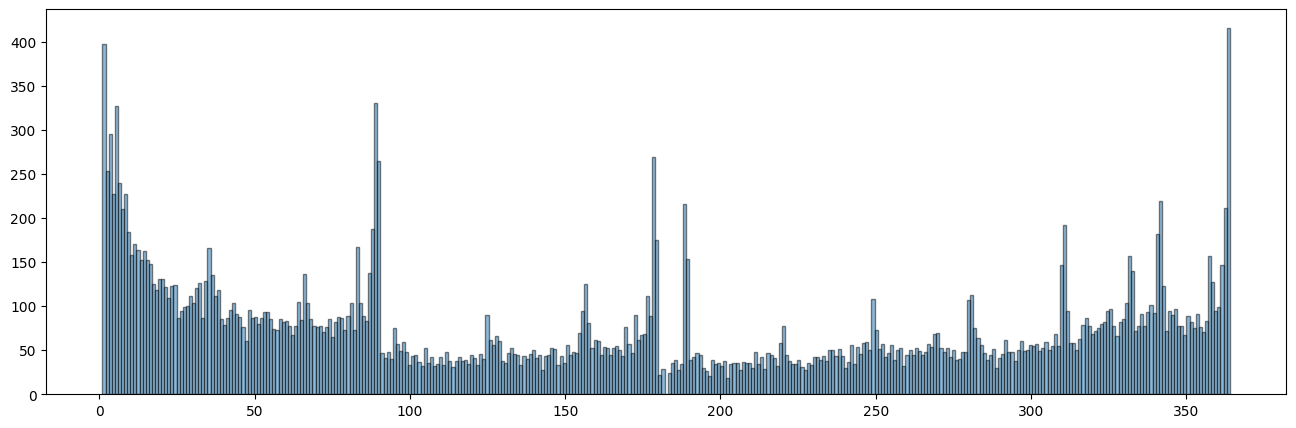

In [59]:
column = df["availability_365"]

_, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 5))

l, u = calculate_iqr(column)
print("IQR range:", l, u)

print("Count of '0' values", column.value_counts()[0])
print("Count of '365' values:", column.value_counts()[365])
ax.hist(column[(column != 0) & (column != 365)], bins=365, alpha=0.5, edgecolor="black")

plt.show()

* Данные о простое в 0 и 365 дней не отображены на гистограмме, так они преобладают, что заструдняло рассмотрение графика.

По анализу IQR данные не содержат выбросов и вцелом достачно сбалансированны, никакие значения отбршены не будут.

### Минимальное количество ночей

Min: 1
Max: 1250
Mean: 6.937968287158041

IQR range: -5.0 11.0


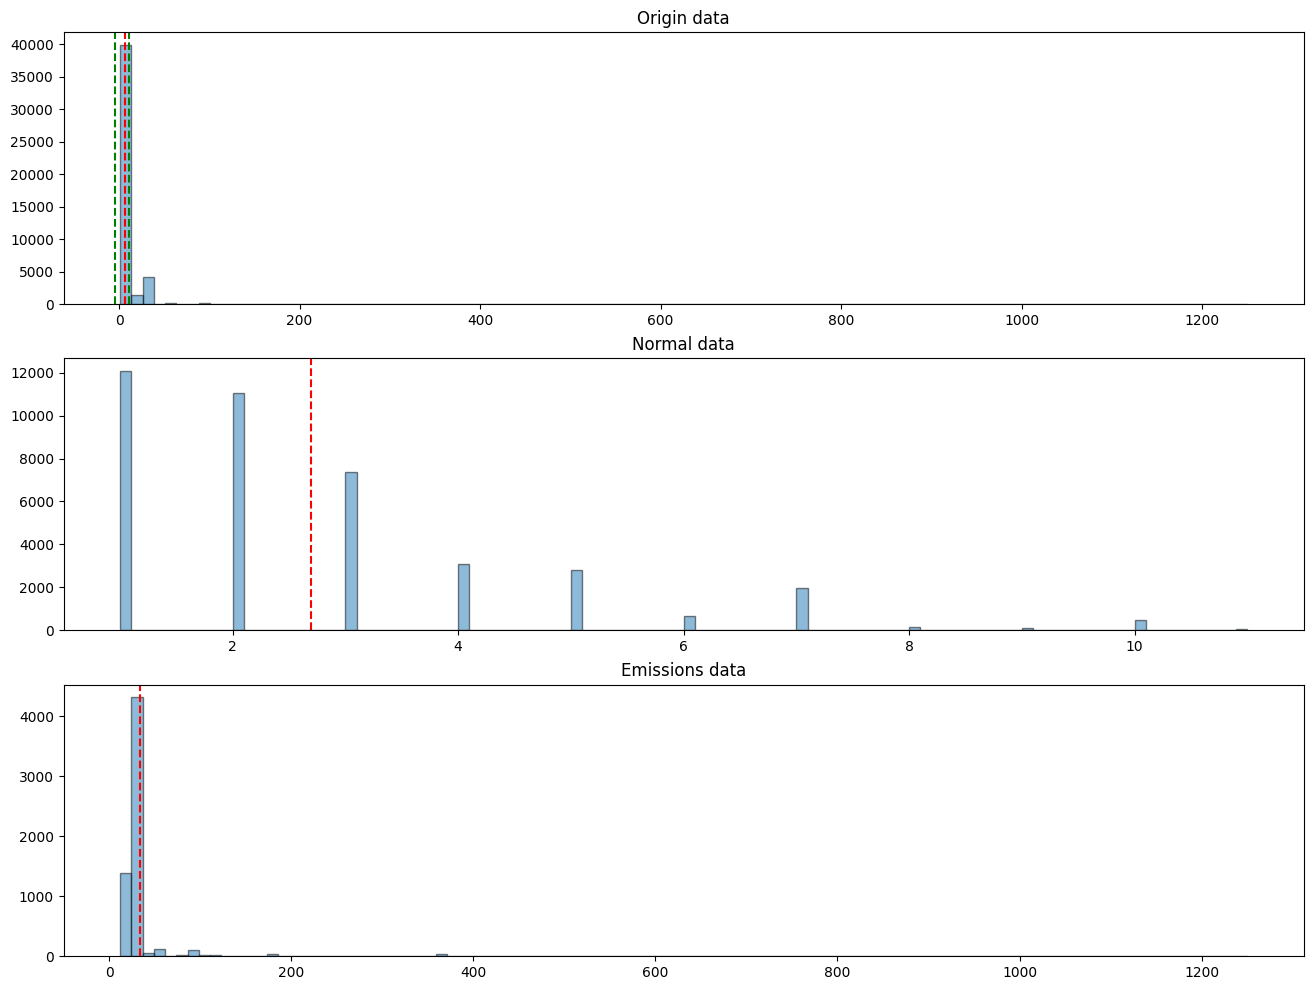

In [61]:
column = df["minimum_nights"]

print("Min:", column.min())
print("Max:", column.max())
print("Mean:", column.mean())

l, u = calculate_iqr(column)
print("\nIQR range:", l, u)

_, ax = plt.subplots(nrows=3, ncols=1, figsize=(16, 12))

ax[0].set_title("Origin data")
ax[0].hist(column, bins=100, alpha=0.5, edgecolor="black")
ax[0].axvline(x=l, color="green", linestyle="--")
ax[0].axvline(x=u, color="green", linestyle="--")
ax[0].axvline(x=column.mean(), color="red", linestyle="--")

col = column[column <= u]
ax[1].set_title("Normal data")
ax[1].hist(col, bins=100, alpha=0.5, edgecolor="black")
ax[1].axvline(x=col.mean(), color="red", linestyle="--")

col = column[column > u]
ax[2].set_title("Emissions data")
ax[2].hist(col, bins=100, alpha=0.5, edgecolor="black")
ax[2].axvline(x=col.mean(), color="red", linestyle="--")

plt.show()

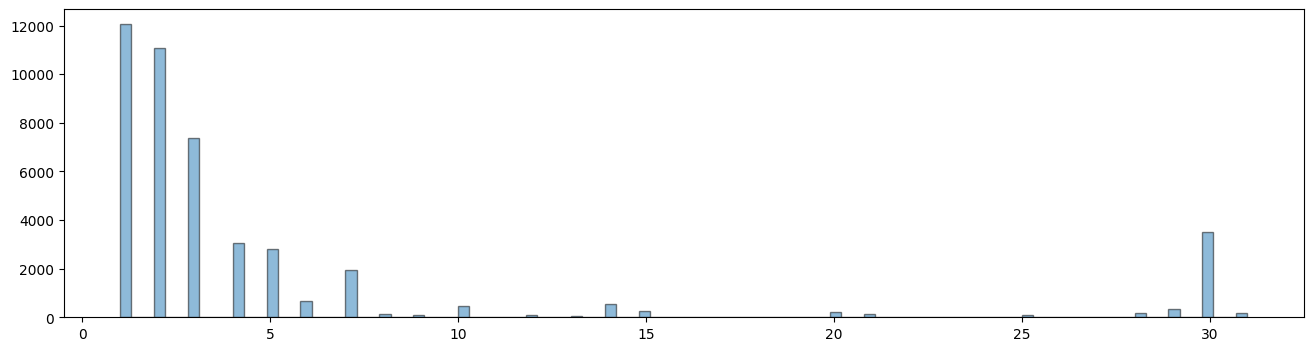

In [62]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))

col = column[column <= 31]
ax.hist(col, bins=100, alpha=0.5, edgecolor="black")

plt.show()

Больше одного месяца скорее всего выбросы, т.к. больше месяца минимальное количество ночей обычно не бывает.

In [63]:
to_delition = len(column[column > 31])
print("Elements count to deletion:", to_delition)
TOTAL_DELITIONS += to_delition

df = df[df["minimum_nights"] <= 31]

Elements count to deletion: 497


### Количество объявлений

Min: 1
Max: 327
Mean: 6.645029175382583

IQR range: -0.5 3.5
-0.5 3.5


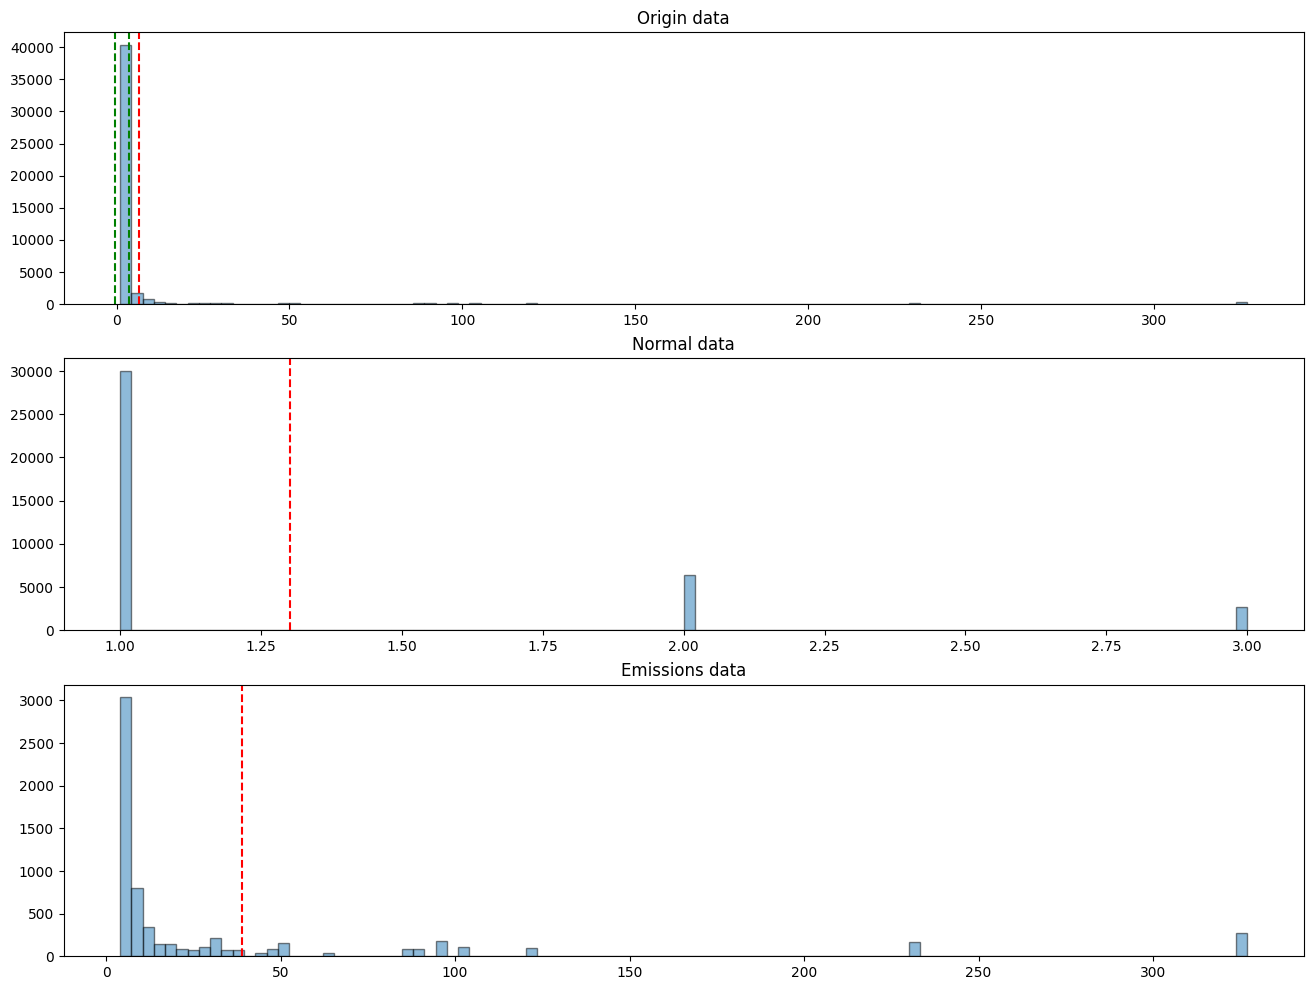

In [65]:
column = df["calculated_host_listings_count"]

print("Min:", column.min())
print("Max:", column.max())
print("Mean:", column.mean())

l, u = calculate_iqr(column)
print("\nIQR range:", l, u)

print(l, u)

_, ax = plt.subplots(nrows=3, ncols=1, figsize=(16, 12))

ax[0].set_title("Origin data")
ax[0].hist(column, bins=100, alpha=0.5, edgecolor="black")
ax[0].axvline(x=l, color="green", linestyle="--")
ax[0].axvline(x=u, color="green", linestyle="--")
ax[0].axvline(x=column.mean(), color="red", linestyle="--")

col = column[column <= u]
ax[1].set_title("Normal data")
ax[1].hist(col, bins=100, alpha=0.5, edgecolor="black")
ax[1].axvline(x=col.mean(), color="red", linestyle="--")

col = column[column > u]
ax[2].set_title("Emissions data")
ax[2].hist(col, bins=100, alpha=0.5, edgecolor="black")
ax[2].axvline(x=col.mean(), color="red", linestyle="--")

plt.show()

Диапазон значений выглядит нормально, но данные крайне несбалансированы, пока ничего не будет удалено, но необходимо проверить, будет ли улучшение при частичном удалении элементов, или полного удаления признака.

### Отзывы